# MODELO FINAL

El modelo escogido para clasificar si el precio del mercado intradiario 1 será inferior (RESERVA = 1) o superior (RESERVA = 0) al precio del mercado diario, tras estudiar varias opciones (*Modelo_Clasificador_1.ipynb, Modelo_Clasificador_2.ipynb, Modelo_Clasificador_3.ipynb, Modelo_XGBoos_FSelect.ipynb* dentro de la carpeta *Modelo*), es:

* Modelo XGBoost, n_estimators=500.
* Features:

    * **PERIODO**: variable categórica que representa la hora del día expresado como la finalización de la hora de estudio. 

    * **WD**: variable categórica que toma valores del 1 al 7 para describir el día de la semana. Los festivos nacionales se han considerado tipo 7 (domingo).

    * **PRECIO_MD_ESP**: variable cuantitativa del precio de casación en el mercado diario para un PERIODO, FECHA.

    * **P48_EOLICA**: Variable cuantitativa de la producción eólica horaria. 

    * **P48_DEMANDA**: Variable cuantitativa de la demanda horaria.

    * **POT_DISP_CARBON**: Variable cuantitativa de la potencia de generación disponible de carbón.

    * **CARBON_D-1**: Variable cuantitativa creada en el notebook *Exploracion_datos.ipynb* resultado de dividir la producción de carbón horaria que hubo el día anterior entre el número de centrales de carbón que estaban arrancadas.

    * **EMB_ANUALES y EMB_HIPERANUALES**: Variable cuantitativa del total peninsular de la cantidad de energía eléctrica que se produciría en su propia central y en todas las centrales situadas aguas abajo, con el vaciado completo de su reserva útil de agua en dicho momento, en el supuesto de que este vaciado se realice sin aportaciones naturales. Los primeros son aquellos cuyo ciclo de llenado y vaciado dura un año mientras que los embalses de régimen hiperanual son aquellos que permiten compensar las variaciones de hidraulicidad en ciclos de más de un año de duración.
    
* Tamaño dataset: 2 años hidráulicos - desde 01/10/2016 - 30/09/2018

En este notebook se analiza el resultado obtenido y la salida que ofrece de cara a utilizarlo en producción. 

Importamos librerías necesarias:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import altair as alt

%matplotlib inline
plt.style.use('ggplot')

#Librerías para modelos

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report, confusion_matrix, precision_score

#Para representar el arbol

import pydotplus
from IPython.display import Image
from ipywidgets import interact
from sklearn import tree
import graphviz     #conda install python-graphviz

El modelo escogido es el Modelo_4, guardado en la ruta:

In [2]:
path='/Users/blancabengoa/Desktop/KSchool/TFM/Modelo4/'

*Nota: El resultado de este modelo y el set de entrenamiento y test se han subido a Github en la carpeta **Resultados/data&model/**. Para utilizar este notebook, descargar estos ficheros en alguna ruta local del ordenador y modificar la variable path*

Extraigo la división utilizada de train-test y nos traemos el dataset completo:

In [3]:
X_train = pickle.load(open(path + "X_train.pkl","rb"))
X_test = pickle.load(open(path + "X_test.pkl","rb"))
y_train = pickle.load(open(path + "y_train.pkl","rb"))
y_test = pickle.load(open(path + "y_test.pkl","rb"))
model=pickle.load(open(path + "clfxb_4.pkl","rb"))

In [4]:
attributes_column=X_train.columns
list(attributes_column)

['PERIODO',
 'WD',
 'PRECIO_MD_ESP',
 'P48_EOLICA',
 'P48_DEMANDA',
 'POT_DISP_CARBON',
 'CARBON_D-1',
 'EMB_ANUALES',
 'EMB_HIPERANUALES']

Extraigo también el dataset completo, con la fecha.

In [5]:
df=pd.read_csv('../data_processed/data_processed_definitive.csv',sep=';',index_col=False,parse_dates=['FECHA'])
df_new=df[df['FECHA']>'2016-09-30'].copy()
df_new=df_new.drop(['ACOPLADO_FR','RESERVA_D-1','MES'],axis=1).copy()

X=df_new[attributes_column]
y=df_new['RESERVA']

## RESULTADO: 

### Feature importances

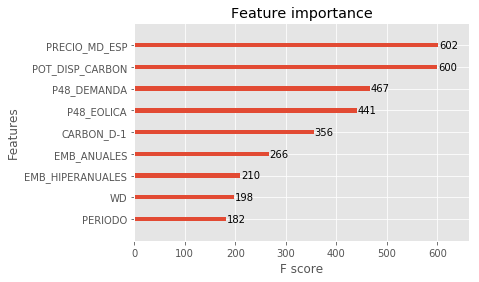

In [6]:
plot_importance(model,importance_type='weight')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

La variable más utilizada para dividir los árboles es PRECIO_MD_ESP, casi empatada con POT_DISP_CARBON.

A pesar de que la importancia de las variables, en cuanto a su utilidad en la división de los árboles, disminuye drásticamente para n>5, en el notebook *Modelo_XGBoost_FSelect.ipynb* dentro de la carpeta *Modelo*, se analizó que el accuracy del modelo decrecía con el número de variables a considerar con n<9. 

### Árboles que componen el modelo:

Para ayudar a la interpretación de las variables.

*Nota: El notebook debe abrirse en jupyter notebook*

In [8]:
@interact(trees=np.arange(500))
def show(trees):
    plot_tree(model,num_trees=trees)
    plt.rcParams['figure.figsize'] = [50, 50]
    plt.show()

interactive(children=(Dropdown(description='trees', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

Ejemplo tree = 1:

Una de las divisiones que considera es si el día de la semana es <7. Recordando el notebook *Exploracion_datos.ipynb*, WD=7 mostraba un comportamiento distinto (y más sesgado a que RESERVA=1) que el resto de posibles valores de RESERVA.

Para convertir el valor de leaf a probabilidad de RESERVA = 1, basta con hacer la siguiente operación:

(Ejemplo, POT_DISP_CARBON<8819 -> WD >=7 -> PRECIO_MD_ESP < 59.18)

In [9]:
print("Probabilidad: %.2f" %((1/(1+np.exp(-1*0.0718879)))*100) + "%")

Probabilidad: 51.80%


### Métricas obtenidas

In [10]:
print(classification_report(y_test,model.predict(X_test)))
print("Accuray: %.2f" %(accuracy_score(y_test,model.predict(X_test))*100) + "%")
print("Precision: %.2f" %(precision_score(y_test,model.predict(X_test))*100) + "%")

             precision    recall  f1-score   support

          0       0.70      0.54      0.61      1518
          1       0.70      0.83      0.76      1986

avg / total       0.70      0.70      0.69      3504

Accuray: 70.15%
Precision: 70.00%


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


El accuracy del modelo no es muy elevado (70,15%).

El target RESERVA vale 1 un 57% de las veces. Eso quiere decir que, si mi estrategia fuese apostar siempre a que el precio del intradiario baja, acertaría un 57% de las veces. 

Con el modelo seleccionado, acierto un 13% más.

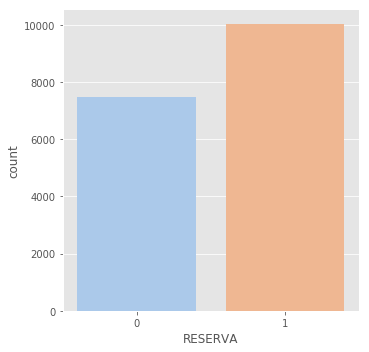

RESERVA = 1: 57.22%


In [11]:
g=sns.catplot('RESERVA',data=df_new,kind='count',palette='pastel')
plt.show()
print("RESERVA = 1: %.2f" %(df_new['RESERVA'].value_counts(normalize=True)[1]*100) + "%")

Incluyo la probabilidad con la que ha selecionado esa salida, para intentar ver si mi porcentaje de acierto aumenta cuando solo hago caso al modelo cuando me predice con cierta probabilidad, sin perder muchas oportunidades.

### Análisis probabilidades: predict_proba()

In [12]:
prob=list(model.predict_proba(X_test))
pred=list(model.predict(X_test))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
df_pred_prob=pd.DataFrame(prob,columns=['PROB_0','PROB_1'])
df_pred_prob.head()

,PROB_0,PROB_1
0,0.588170,0.411830
1,0.525154,0.474846
2,0.504295,0.495705
3,0.497604,0.502396
4,0.360216,0.639784


In [14]:
df_pred_prob['PRED']=pred
df_pred_prob['TRUE']=list(y_test)
df_pred_prob.head()

,PROB_0,PROB_1,PRED,TRUE
0,0.588170,0.411830,0,1
1,0.525154,0.474846,0,1
2,0.504295,0.495705,0,0
3,0.497604,0.502396,1,1
4,0.360216,0.639784,1,1


Creo dos conjuntos: 

* Baja intra: Cuando True=1 (RESERVA=1 real)
* Sube intra: Cuando True=0 (RESERVA=0 real)

In [15]:
BAJA_INTRA=df_pred_prob[df_pred_prob['TRUE']==1].copy().reset_index(drop=True)
SUBE_INTRA=df_pred_prob[df_pred_prob['TRUE']==0].copy().reset_index(drop=True)

#### BAJA INTRA:

* Aciertos:

In [16]:
BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1'].describe()

count    1645.000000
mean        0.702404
std         0.109452
min         0.500345
25%         0.615492
50%         0.700513
75%         0.787501
max         0.980100
Name: PROB_1, dtype: float64

La probabilidad media con la que clasifica como 1 (baja intra) y es 1 (acierta) es del 70%. Tan solo en un 25% de los casos de acierto la probabilidad era inferior al 62%.

* Fallos:

In [17]:
BAJA_INTRA[BAJA_INTRA['PRED']==0]['PROB_0'].describe()

count    341.000000
mean       0.607196
std        0.083213
min        0.500007
25%        0.538656
50%        0.590101
75%        0.649176
max        0.966778
Name: PROB_0, dtype: float64

La probabilidad media con la que clasifica como 0 (sube intra) y es 1 es del 60%. Un 75% de los fallos los predijo con una probabilidad inferior al 65%. 

#### SUBE INTRA:

* Aciertos:

In [18]:
SUBE_INTRA[SUBE_INTRA['PRED']==0]['PROB_0'].describe()

count    813.000000
mean       0.669829
std        0.116388
min        0.500384
25%        0.571453
50%        0.650337
75%        0.761883
max        0.958478
Name: PROB_0, dtype: float64

La probabilidad media con la que clasifica como 0 (sube intra) y es 0 es del 67%. Tan solo en un 25% de los casos de acierto la probabilidad era inferior al 57%.

In [19]:
SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1'].describe()

count    705.000000
mean       0.634077
std        0.091261
min        0.500081
25%        0.556696
50%        0.623030
75%        0.697530
max        0.899994
Name: PROB_1, dtype: float64

La probabilidad media con la que clasifica como 1 (baja intra) y es 0 (sube intra, falla) es del 63%. Un 75% de los fallos los predijo con una probabilidad inferior al 70%. 

**CONCLUSIÓN 1:**

* Cuando la predicción es **RESERVA=1**, exigiré que la **probabilidad** con la que lo predice sea **>=70%**, si no no hago nada (todo al MD).

* Cuando la predicción es **RESERVA=0**, exigiré que la **probabilidad** con la que lo predice sea **>=65%**, si no no hago nada (todo al MD).

*Nota: el motivo por el que me voy al percentil 75 en el caso de apostar a subir el intra es por las características del mercado eléctrico: la estrategia de comprar de más en el mercado diario siempre se realiza con más cautela.*

Graficamente se ve como a partir de una probabilidad > 70%, el número de veces que clasifica RESERVA = 1 y acierta supera a las que falla: 

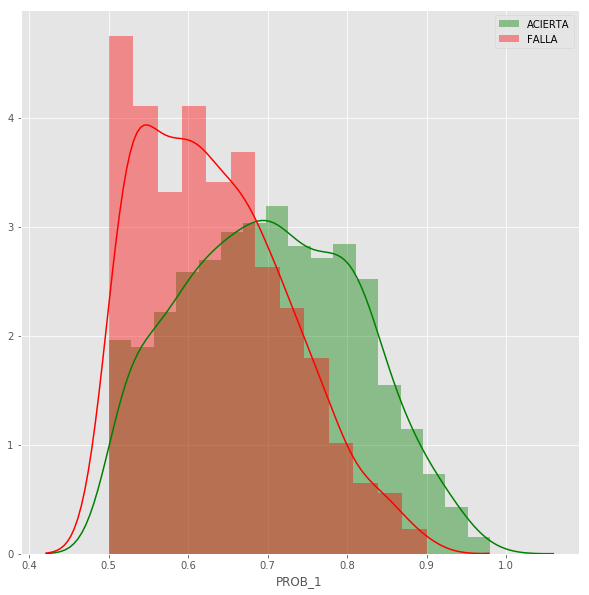

In [20]:
f, ax = plt.subplots(1, 1,figsize=[10,10])

sns.distplot(BAJA_INTRA[BAJA_INTRA['PRED']==1]['PROB_1'],ax=ax,color='green');
sns.distplot(SUBE_INTRA[SUBE_INTRA['PRED']==1]['PROB_1'],ax=ax,color='red');

ax.legend(labels=["ACIERTA","FALLA"]) 

plt.show()

En el caso de RESERVA = 0 la distribución de fallos se desplaza más a la izquierda, considerando los resultados más fiables a menor probabilidad predicha. Me quedo con el percentil 75 (probabilidad mínima exigida del 65%)

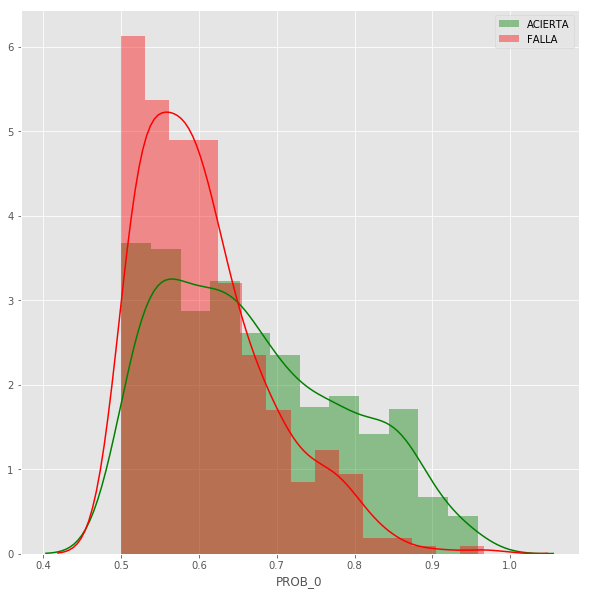

In [21]:
f, ax = plt.subplots(1, 1,figsize=[10,10])

sns.distplot(SUBE_INTRA[SUBE_INTRA['PRED']==0]['PROB_0'],ax=ax,color='green');
sns.distplot(BAJA_INTRA[BAJA_INTRA['PRED']==0]['PROB_0'],ax=ax,color='red');

ax.legend(labels=["ACIERTA","FALLA"]) 

plt.show()

Falta comprobar cuántas oportunidades pierdo en los huecos de aciertos entre la probabilidad del 50% y la mínima exigida:

In [22]:
print("%.2f" %(BAJA_INTRA[(BAJA_INTRA['PRED']==1) & (BAJA_INTRA['PROB_1']<0.7)]['PRED'].count()/len(BAJA_INTRA['PRED'])*100) + "%")

41.19%


Hay un 41% de las veces que me quedo de brazos cruzados y hubiese acertado ¿cuántas veces ocurre esto cuando predict_proba < 65%?

In [23]:
print("%.2f" %(BAJA_INTRA[(BAJA_INTRA['PRED']==1) & (BAJA_INTRA['PROB_1']<0.6)]['PRED'].count()/len(BAJA_INTRA['PRED'])*100) + "%")

17.12%


Si bajo mi exigencia al 65%, tan solo pierdo un 17% de oportunidades. 

In [24]:
print("%.2f" %(SUBE_INTRA[(SUBE_INTRA['PRED']==0) & (SUBE_INTRA['PROB_0']<0.65)]['PRED'].count()/len(SUBE_INTRA['PRED'])*100) + "%")

26.68%


Hay un 26% de las veces que me quedo de brazos cruzados y hubiese acertado.

**CONCLUSIÓN 2:**

* Cuando la predicción es **RESERVA=1**

        * Dejaré de comprar una cantidad mínima residual apostando a que baja el intradiario, si la probabilidad está comprendida entre el **60% - 70%** (aumentando volumen a valores normales según se aproxime al 70%)
        * Estrategia de dejar de comprar "normal" cuando la **probabilidad** con la que lo predice sea **>=70%**
        * En otro caso, no hago nada (todo al MD).

* Cuando la predicción es **RESERVA=0**, exigiré que la **probabilidad** con la que lo predice sea **>=65%**, si no no hago nada (todo al MD).



### ¿Cómo mejora mi acierto teniendo en cuenta predict_proba?

In [25]:
A=BAJA_INTRA[(BAJA_INTRA['PROB_1']>0.6)]['PRED'].count()+SUBE_INTRA[(SUBE_INTRA['PROB_0']>0.65)]['PRED'].count()

In [26]:
B=(df_pred_prob[df_pred_prob['PROB_1']>0.6]['PRED'].count()+df_pred_prob[df_pred_prob['PROB_0']>0.65]['PRED'].count())

In [27]:
print("Nuevo porcentaje acierto: %.2f" %(A/B*100) + "%")

Nuevo porcentaje acierto: 77.51%


### Resumen:

A la hora de aplicar el modelo clasificador de si baja o sube el precio del intradiario, obtendré tanto la predicción como la probabilidad con la que predice, y actuaré siguiendo el siguiente patrón:

* Cuando la predicción es **RESERVA=1**

        * Dejaré de comprar una cantidad mínima residual apostando a que baja el intradiario, si la probabilidad está comprendida entre el **60% - 70%** (aumentando volumen a valores normales según se aproxime al 70%)
        * Estrategia de dejar de comprar "normal" cuando la **probabilidad** con la que lo predice sea **>=70%**
        * En otro caso, no hago nada (todo al MD).

* Cuando la predicción es **RESERVA=0**, exigiré que la **probabilidad** con la que lo predice sea **>=65%**, si no no hago nada (todo al MD).


Guardo el dataset df_pred_prob en *Resultados/data&model/

In [28]:
df_pred_prob.to_csv('./data&model/pred_prob.csv',sep=';',index= False)